## Import Python Module

In [58]:
#gestion fichier modeles pythons
import os , sys            
workpath = sys.path[0]

sys.path.append(f'{workpath}\fidle-env\lib\site-packages')

#modules utilitaires
import random as r
import numpy as np
import time as t
import fidle
   
#traitement image
import matplotlib.pyplot as plt   
from skimage import io 

#module IA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import Model

#module de convertion d'image gris a RGB
import cv2



## les diffs choix de dataset.

In [4]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_64"
#fidle.utils.mkdir(".\trained_model")
fidle.utils.mkdir(run_dir)

In [59]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_256'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_256"
#fidle.utils.mkdir(".\trained_model")
fidle.utils.mkdir(run_dir)

In [25]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64_sans_bruit'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_64_sans_bruit"
fidle.utils.mkdir(run_dir)

In [ ]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64_fullmodif'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_256_dataugmentation"
fidle.utils.mkdir(run_dir)

In [ ]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_64_mix'
run_dir="E:\INSA-cour\A4A\Projet_multi\work-dictory\\trained_model\model_256_semi_dataugmentation"
fidle.utils.mkdir(run_dir)

## Parameters for CNN and DNN

In [60]:
#pourcentage du dataset à load
scale = 0.3  #si on fait 256

#batch_size    = 64 # le batch size initial
batch_size    = 64
epochs        = 10
fit_verbosity = 1

index_to_class = ["CUBO","DEC","FCC","FCC-sphere","HCP-sphere","ICO","MnBeta_sphere","OH","RTD","BCC","DODECA"]

## Dataset loading

In [61]:
def read_dataset (filepath : str):
    """entrée : chemin vers le dossier contenant la BDD
    sortie : listes des images et leur classes respectives, mis à l'échelle (scale) et mélangées"""
    
    L = os.listdir(filepath)   #liste contenenant le nom (en .jpg) de toutes les images
    nb_files = len(L)
    nb_files2load = round(nb_files*scale)
    size = np.shape(io.imread(f'{filepath}/{L[0]}'))  #enlevant le as_gray =  True
    
    #initialisation listes sortie
    img = np.zeros ( (nb_files2load , size[0] , size[1]) , dtype = np.float16 )
    ID  = np.zeros ( nb_files2load , dtype = np.int8)
   
    for i in range (nb_files2load):
        
        random_index = r.randint(0 , nb_files - i - 1)
        img[i] = io.imread (f'{filepath}/{L[random_index]}', as_gray =  True)     #avec couleur: enlevant le as_gray =  True
        ID [i] = int (L[random_index][:3]) - 1
        L.pop(random_index)
        
    N = len(img)
    img_train = img[0:round(N*0.8)]
    img_test  = img[round(N*0.8):]
    ID_train = ID[0:round(N*0.8)]
    ID_test  = ID[round(N*0.8):]   
        
    return img_train,img_test,ID_train,ID_test


img_train , img_test , ID_train , ID_test = read_dataset(datapath) 

print(f'chaining dataset actual is {datapath}')
print(np.shape(img_train))
print(np.shape(img_test))
print(np.shape(ID_train))
print(np.shape(ID_test))

chaining dataset actual is E:\INSA-cour\A4A\Projet_multi\work-dictory\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_256
(4810, 256, 256)
(1202, 256, 256)
(4810,)
(1202,)


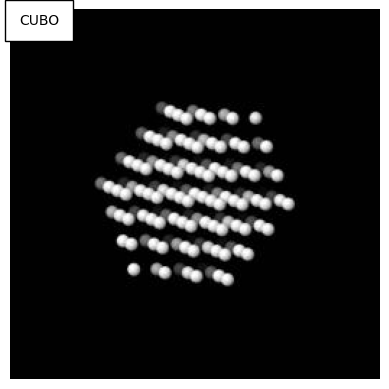

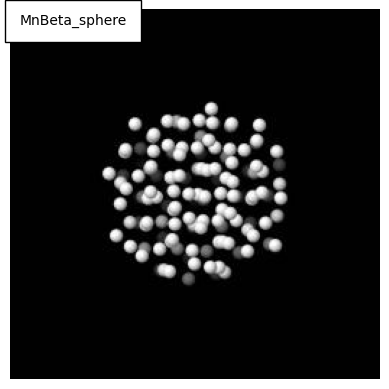

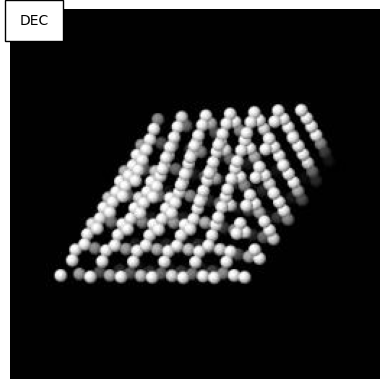

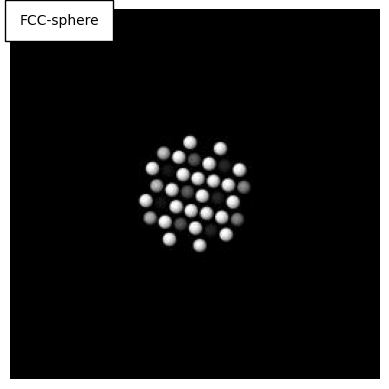

In [62]:
for i in range(4):
    fig, ax = plt.subplots()
    plt.imshow(img_train[i], cmap ="gray") #avec couleur: enlevant , cmap ="gray"
    plt.axis("off")
    ax.text(6,10,index_to_class[ID_train[i]], bbox={'facecolor': 'white', 'pad': 10})

## Model creation

In [63]:
def create_model3_3(lx,ly): #le 3_ :il y a 2 couche de dense
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,1)))
    model.add( keras.layers.MaxPooling2D((3, 3)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    #model.add( keras.layers.Conv2D(256, (3, 3), activation='relu')) 
    #model.add( keras.layers.MaxPooling2D((2, 2)))
    #model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(5000, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    
    model.add( keras.layers.Dense(5000, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(11, activation='softmax'))
    return model

code_model='3_3'

(nb_img,lx,ly) = np.shape(img_train)
model = create_model3_3(lx,ly)

In [64]:

model_name = 'e'+str(epochs)+'bs'+str(batch_size)+'sc'+str(scale)+'code'+str(code_model)

print(model_name)

e10bs64sc0.3code3_3


## get output of some layers by index

In [65]:
# cette cellure contient des commands basique pour recuperer un lame
#print(model.layers) #print tous les layers  
layer8=model.layers[8]
convol_output=layer8.output
print(convol_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 128), dtype=tf.float32, name=None), name='dropout_7/Identity:0', description="created by layer 'dropout_7'")


(256, 256, 1)
(1, 256, 256, 1)
1/1 [==============================] - 1s 547ms/step


(-0.5, 255.5, 255.5, -0.5)

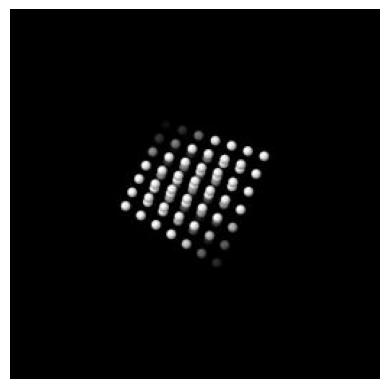

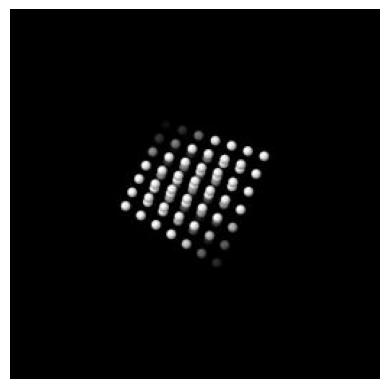

In [66]:
#layer_model: le layer avant flatten
layer_model= Model(inputs = model.input, outputs = convol_output)
#ajouter des dim pour que la forme de matrix d'image adapte les fonctions de keras
random_index = r.randint(0 , 4810)
img_init = img_train[random_index]
img_tridim = img_train[random_index][:,:,np.newaxis]
print(np.shape(img_tridim))
img_quadim = img_tridim[np.newaxis,:,:,:] #ici le dim de matric d'img est 4, mais rien ne change pas 
print(np.shape(img_quadim))
"""
fig, ax = plt.subplots()
plt.imshow(img_tridim, cmap ="gray") #avec couleur: enlevant , cmap ="gray"
plt.axis("off")
"""
#convoluer l'image
img_convolued = layer_model.predict(img_quadim)

fig, ax = plt.subplots()   #image apres convolution
plt.imshow(img_quadim[0], cmap ="gray")
plt.axis("off")
fig, ax = plt.subplots() #cela est l'image avant convolution
plt.imshow(img_init, cmap ="gray")
plt.axis("off")

## connaitre les hyperparametre de model

In [43]:
hyperparas = model.get_weights() #les poids de models c'est pas ce que je veux
print(np.shape(hyperparas[0]))

(3, 3, 1, 32)


## Training

In [17]:
print(np.array([1]))

[1]


In [ ]:
t1 = t.time()

# ---- Shuffle train data

img_train , ID_train = fidle.utils.shuffle_np_dataset(img_train,ID_train)

# ---- Train

history = model.fit(  img_train, ID_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (img_test,ID_test ),  
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback])

path1=f'{models_path}\models\last_model_{model_name}.h5'
model.save(path1) 

t2 = t.time()
print(f'Exécution en {t2-t1} secondes')

Datasets have been shuffled.
Epoch 1/10
251/251 [==============================] - ETA: 0s - loss: 1.7989 - accuracy: 0.3084

In [ ]:
hours = int((t2-t1)/3600)
mins = int(np.mod(t2-t1,3600)/60)
seconds = int (np.mod(np.mod(t2-t1,3600),60))
run_time = f'{hours}h{mins}mins{seconds}seconds'
os.rename(f'{models_path}/models',f'{models_path}/models_{run_time}')
path1=f'{models_path}/models_{run_time}/last_model_{model_name}.h5'

In [ ]:
print(run_time)